In [51]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [52]:
# Set the root directory for data files (use Google Drive if on Colab)
# ROOT_DIR = "gdrive/MyDrive/DataStunt/CNN/"
ROOT_DIR = "../Input/"

In [53]:
# Install the required libraries
!pip install numpy opencv-python-headless torch matplotlib pandas torchvision


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
# Import required Python libraries for handling images and datasets
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [55]:
# Specify the training folder location
Training_folder = ROOT_DIR + "Data/Training_data"
os.listdir(Training_folder)  # List all files in the training folder

['driving_license', 'others', 'social_security']

In [56]:
# Import PyTorch's ImageFolder utility for organizing image datasets
from torchvision.datasets import ImageFolder
ImageFolder(Training_folder)

Dataset ImageFolder
    Number of datapoints: 600
    Root location: ../Input/Data/Training_data

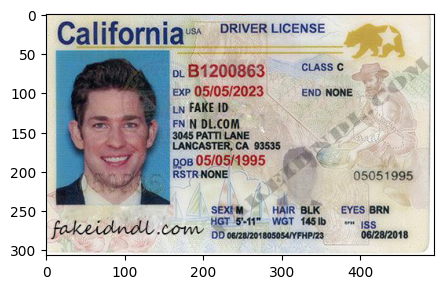

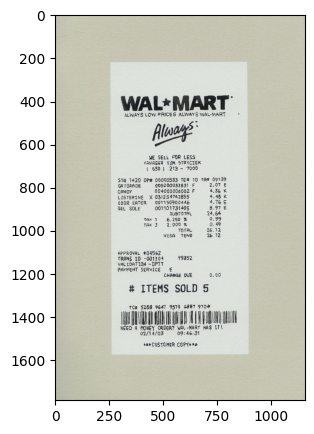

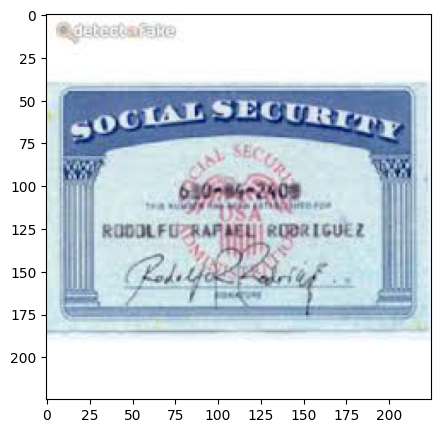

In [57]:
# Display random images from the dataset for visualization
for path in os.listdir(Training_folder):
    for i in range(1):
        temp_path = Training_folder + "/" + path
        file = random.choice(os.listdir(temp_path))
        image_path = os.path.join(temp_path, file)
        img = mpimg.imread(image_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(img)

In [58]:
# Set the image dimensions and specify folders for train and test data
IMG_WIDTH = 200
IMG_HEIGHT = 200
Train_folder = ROOT_DIR + 'Data/Training_data'
Test_folder = ROOT_DIR + 'Data/Testing_Data'

In [59]:
def create_dataset(Train_folder, img_width=200, img_height=200):
    img_data_array = []
    class_name = []
    classes = {'driving_license': [1,0,0], 'others': [0,1,0], 'social_security': [0,0,1]}
    
    for class_folder in os.listdir(Train_folder):
        for file in os.listdir(os.path.join(Train_folder, class_folder)):
            image_path = os.path.join(Train_folder, class_folder, file)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            
            # Ensure the image was loaded correctly
            if image is None:
                print(f"Error loading image: {image_path}")
                continue
            
            # Check if the image has 3 channels (RGB)
            if len(image.shape) == 3 and image.shape[2] == 3:
                image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
                image = image.astype('float32') / 255.0  # Normalize to [0, 1]
                img_data_array.append(image.transpose(2, 0, 1))  # Convert to channel-first format for PyTorch
                class_name.append(classes[class_folder])  # Append class label
            else:
                print(f"Skipping non-RGB image: {image_path}")
    
    return np.array(img_data_array), np.array(class_name)


In [60]:
# Extract the image data and class labels for training and testing datasets
Train_img_data, train_class_name = create_dataset(Train_folder)
Test_img_data, test_class_name = create_dataset(Test_folder)
# extract the image array and class name for training data
Train_img_data, train_class_name = create_dataset(Train_folder)

# extract the image array and class name for testing data
Test_img_data, test_class_name =create_dataset(Test_folder)

Skipping non-RGB image: ../Input/Data/Training_data\others\463.png
Skipping non-RGB image: ../Input/Data/Training_data\others\472.jpg
Skipping non-RGB image: ../Input/Data/Training_data\others\595.jpg
Skipping non-RGB image: ../Input/Data/Testing_Data\others\147.png
Skipping non-RGB image: ../Input/Data/Training_data\others\463.png
Skipping non-RGB image: ../Input/Data/Training_data\others\472.jpg
Skipping non-RGB image: ../Input/Data/Training_data\others\595.jpg
Skipping non-RGB image: ../Input/Data/Testing_Data\others\147.png


In [61]:
# Check the first class label in the training set
train_class_name[0]

array([1, 0, 0])

In [62]:
# Print the number of training samples
len(Train_img_data)

597

In [63]:
# Import required PyTorch libraries for creating the model
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.utils.data as Data
from torch import Tensor
from torch.autograd import Variable

In [64]:
# Check PyTorch version
print(torch.__version__)

2.4.1+cpu


In [65]:
# Convert the dataset to PyTorch tensors
torch_dataset_train = Data.TensorDataset(Tensor(np.array(Train_img_data)), Tensor(np.array(train_class_name)))
torch_dataset_test = Data.TensorDataset(Tensor(np.array(Test_img_data)), Tensor(np.array(test_class_name)))

In [66]:
# Define DataLoader for loading training and test datasets in batches
trainloader = torch.utils.data.DataLoader(torch_dataset_train, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(torch_dataset_test, batch_size=8, shuffle=True)

In [67]:
# Check the shape of training data from the DataLoader
dataiter = iter(trainloader)
images = next(dataiter)
images[0].shape

torch.Size([8, 3, 200, 200])

In [68]:
# Define the architecture for the CNN model using PyTorch
class CNNNet(nn.Module):   
  def __init__(self):
      super(CNNNet, self).__init__()

      # Define convolutional layers
      self.cnn_layers = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),  # First conv layer
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling layer
          nn.Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1)),  # Second conv layer
          nn.MaxPool2d(kernel_size=1, stride=1)  # Pooling layer
      )
    
      # Define fully connected (linear) layers
      self.linear_layers = nn.Sequential(
          nn.Linear(3, 3)  # Output layer with 3 classes
      )

  # Define the forward pass
  def forward(self, x):
      x = self.cnn_layers(x)  # Apply convolutional layers
      x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
      x = self.linear_layers(x)  # Apply fully connected layers
      return x

# Define the optimizer and loss function 
model = CNNNet()  # Initialize the model
optimizer = optim.SGD(model.parameters(), lr=0.0001)  # Use stochastic gradient descent
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification

# Check if GPU is available, and move model and loss function to GPU if available
print(torch.cuda.is_available())
if torch.cuda.is_available():
    model = model.to("cuda")
    criterion = criterion.to("cuda")
    
print(model)

False
CNNNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1))
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
  )
)


In [69]:
# Train the model for 10 epochs
for i in range(10):
    running_loss = 0
    model.train()  # Set model to training mode
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images = images.to("cuda")
            labels = labels.to("cuda")
    
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images)
        
        # Calculate the loss
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {i+1} - Training loss: {running_loss/len(trainloader)}")

Epoch 1 - Training loss: 1.1391905275980632
Epoch 2 - Training loss: 1.0988869881629943
Epoch 3 - Training loss: 1.0739161626497904
Epoch 4 - Training loss: 1.056002009709676
Epoch 5 - Training loss: 1.0437093186378479
Epoch 6 - Training loss: 1.0329026556015015
Epoch 7 - Training loss: 1.0213514455159505
Epoch 8 - Training loss: 1.0135625926653544
Epoch 9 - Training loss: 1.0042061376571656
Epoch 10 - Training loss: 0.9938314270973205


In [70]:
# Save the trained model to a file
filepath = '../output/' + "model.pt"
torch.save(model.state_dict(), filepath)

In [71]:
# model_trained = CNNNet()
# model_trained.load_state_dict(torch.load(filepath))

In [72]:
# device = "cuda"--> use if you have GPU

In [73]:
# Model prediction on the test set
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in testloader:
        x_batch, y_batch = x_batch.to(), y_batch.to()
        y_test_pred = model(x_batch)
        print(y_test_pred)
        _, y_pred_tag = torch.max(y_test_pred, dim=1)  # Get the predicted class
        y_pred_list.extend(y_pred_tag.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

tensor([[-0.2015, -0.1833, -0.6097],
        [-0.1867, -0.2459, -0.5089],
        [-0.2991, -0.0617, -0.1291],
        [-0.2963, -0.0860, -0.5515],
        [-0.2834, -0.0529,  0.0819],
        [-0.2521, -0.1407, -0.4332],
        [-0.0601, -0.3502, -0.2012],
        [-0.2787, -0.1133, -0.4639]])
tensor([[-0.1258, -0.3163, -0.5659],
        [-0.2483, -0.1028,  0.0118],
        [-0.1676, -0.2402, -0.6119],
        [-0.2726, -0.1447, -0.2269],
        [-0.1785, -0.2007, -0.5608],
        [-0.1824, -0.1711, -0.2953],
        [-0.2253, -0.1430, -0.1445],
        [-0.2970, -0.0979, -0.5795]])
tensor([[-0.2634, -0.1160, -0.2360],
        [-0.1161, -0.3221, -0.8291],
        [-0.2726, -0.1447, -0.2269],
        [-0.3208, -0.0300, -0.0765],
        [-0.2908, -0.1034, -0.4967],
        [-0.0595, -0.3070, -0.3072],
        [-0.0032, -0.4270, -0.6859],
        [-0.0119, -0.4145, -0.5953]])
tensor([[-0.0349, -0.4246, -0.9206],
        [-0.3075, -0.1047, -0.5591],
        [-0.1413, -0.2379, -0.2785]

In [74]:
# Convert true labels to class indices
y_true_list_max = [m.argmax() for m in y_true_list]

In [75]:
# Calculate model accuracy
correct_count, all_count = 0, 0
for i in range(len(y_pred_list)):
    if y_pred_list[i] == y_true_list_max[i]:
        correct_count += 1
    all_count += 1
print(f"\nModel Accuracy = {(correct_count/all_count)}")



Model Accuracy = 0.5771812080536913
